Machine Learning for for Kaggle House Price prediction
==================
The basic approach is as follows:


### Data preparation:
1) Define manual transformations that I decided on during explorative data analysis (see `Explorative_Data_Analysis.ipynb`)

2) Apply automatic transformations: one-hot-encoding for categorical columns with > 2 categories, labelencoding for categorical columns with 2 categories, standardizing numeric values (that aren't ordinal in nature).

3) Apply K-Nearest-Neighbour imputation for missing values. For each missing value, look at the nearest neighbour (i.e. most similar house), and use the value from the first neighbour that has it filled in.

### Manual transformation filtering:
4) Transformation Effectiveness: try each manual transformation to determine effectiveness on CV score with a linear model. For each transformation, apply steps 2 and 3 and determine performance compared to baseline. Keep only manual transormations that improve CV score.

### Ensembling
5) Do a cross-validatated Grid Search for a linear model (Ridge regression), Support Vector Regressor and Gradient Boosting Regressor. Calculate ensembled scores (unweighted mean).

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns

from preprocess import prep_data
from utils import rmsle, rmsle_sk, create_submission, create_submission_from_ensemble, \
                  sqrt_transform_helper, log_transform_helper, ihs_transform_helper
from crossval import calc_kfold_score, gridcv
    
%matplotlib inline

In [70]:
COL_Y = 'SalePrice'

## Load data

In [71]:
df_train = pd.read_csv('data/train.csv', index_col='Id')
df_test = pd.read_csv('data/test.csv', index_col='Id')
df_comb = pd.concat((df_train, df_test))

print("n:", len(df_comb), "n_cols: ", len(df_comb.columns))

n: 2919 n_cols:  80


## Some mandatory conversions

These conversion must be performed. Reasons include data that's read incorrectly, has too many missing values for our imputation algorithm to handle, or other code relies on it having been performed.

In [72]:
# The other code assumes log transform on the output variable so it's kind of non-optional:
df_comb[COL_Y] = np.log(df_comb[COL_Y].values)

# Too many missing values:
df_comb = df_comb.drop('Alley', axis=1)  

# MSSubClass is a categorical variable with numeric categories. Prevent treating them as
# numeric/ordinal:
df_comb.loc[:, 'MSSubClass'] = df_comb['MSSubClass'].astype('str')  

# There's very few houses with a pool, only about 13. Too few to impute. I don't think 
# the area of the pool or the quality makes a meaningful difference with numbers this 
# small. Let's make it a boolean and ignore quality.
df_comb['hasPool'] = df_comb['PoolArea'].map(lambda v: 1 if v > 0 else 0)
df_comb = df_comb.drop(['PoolQC', 'PoolArea'], axis=1) 

## Data preprocessing  1 - manual feature engineering

Transformations are registered as functions that take 1 argument, a DataFrame, and return a DataFrame. They're added to a list and then executed sequentially.
By specifying them as functions, rather than executing them directly, we can test what their impact is on the CV score. We'll then only use the ones that actually improve the score.

There isn't much of an ordering in here. I started following the order in Kaggle's `data_description.txt`, but soon realised that that would take too much time, so I started grouping some similar columns and treating them in the same way. Anyway - the order corresponds to the explorative analysis notebook. That notebook contains the rationale for these transformations.

In [6]:
transformations = []

In [7]:
def trans_mssubclass(df_):
    col = 'MSSubClass'
    df_.loc[df_[col].isin(['40', '160']), col] = '40_160'
    df_.loc[df_[col].isin(['70', '20', '75']), col] = '70_20_75'
    df_.loc[df_[col].isin(['190', '50', '90']), col] = '190_50_90'
    df_.loc[df_[col].isin(['30', '45', '180']), col] = '30_45_180'
    df_.loc[df_[col] == '150', col] = np.nan
    return df_
transformations.append(trans_mssubclass)

In [8]:
def trans_lotshape(df_):
    old_col = 'LotShape'
    new_col = 'RegularLotShape'
    df_.loc[df_[old_col] == 'Reg', new_col] = 1
    df_.loc[df_[old_col] == 'IR1', new_col] = 0
    df_.loc[df_[old_col] == 'IR2', new_col] = 0
    df_.loc[df_[old_col] == 'IR3', new_col] = 0
    df_[new_col] = df_[new_col].astype(int)
    df_ = df_.drop(old_col, axis=1)
    return df_
transformations.append(trans_lotshape)

In [9]:
def trans_landcontour(df_):
    df_.loc[:, 'LandLvlOrBnk'] = 0
    df_.loc[df_['LandContour'].isin(('Lvl','Bnk')), 'LandLvlOrBnk'] = 1
    df_ = df_.drop('LandContour', axis=1)
    return df_
transformations.append(trans_landcontour)

In [10]:
def trans_del_utilities(df_):
    return df_.drop('Utilities', axis=1)
transformations.append(trans_del_utilities)

In [11]:
def trans_lotconfig(df_):
    df_.loc[df_['LotConfig'].isin(('FR3','CulDSac')), 'LotConfig'] = 'FR3_or_CulDSac'
    df_.loc[df_['LotConfig'].isin(('Inside','Corner')), 'LotConfig'] = 'Inside_or_Corner'
    return df_
transformations.append(trans_lotconfig)

In [12]:
def trans_landslope(df_):
    old_col_name = 'LandSlope'
    new_col_name = 'LandSlopeGtl'
    df_.loc[:, new_col_name] = 0
    df_.loc[df_[old_col_name].isin(['Gtl']), new_col_name] = 1
    df_ = df_.drop(old_col_name, axis=1)
    return df_
transformations.append(trans_landslope)

In [13]:
def trans_neighborhood(df_):
    old_col_name = 'Neighborhood'
    new_col_name = 'NeighborhoodIndex'
    df_.loc[:, new_col_name] = 1
    
    nb_sp = df_comb.groupby('Neighborhood')[['SalePrice']].median()
    df_.loc[df_[old_col_name].isin(
        nb_sp[nb_sp['SalePrice'] > 200000]
            .index.get_level_values(0).values), new_col_name] = 2
    
    df_.loc[df_[old_col_name].isin(
        nb_sp[nb_sp['SalePrice'] < 160000]
            .index.get_level_values(0).values), new_col_name] = 0
    
    df_ = df_.drop(old_col_name, axis=1)
    return df_
transformations.append(trans_neighborhood)

In [14]:
def trans_add_is_new(df_):
    col = 'IsNew'
    df_.loc[:, col] = 0
    df_.loc[(df_['YearBuilt'] == df_['YrSold']) | 
            (df_['YearBuilt']-1 == df_['YrSold']), col] = 1
    return df_
transformations.append(trans_add_is_new)

In [15]:
def trans_add_remodel(df_):
    col = 'RecentRemodel'
    df_.loc[:, col] = 0
    df_.loc[(df_['YearRemodAdd'] >= df_['YrSold']), col] = 1
    return df_
transformations.append(trans_add_remodel)

In [16]:
def trans_fix_year_remod_add(df_):
    df_.loc[(df_['YearRemodAdd'] == 1950) & 
            (df_['YearBuilt'] < 1950), 'YearBuilt'] = df_['YearBuilt']
    return df_
transformations.append(trans_fix_year_remod_add)

In [17]:
def trans_del_yrsold(df_):
    return df_.drop('YrSold', axis=1)
transformations.append(trans_del_yrsold)

In [18]:
def trans_del_mosold(df_):
    return df_.drop('MoSold', axis=1)
transformations.append(trans_del_mosold)

In [19]:
def trans_del_roofmatl(df_):
    return df_.drop('RoofMatl', axis=1)
transformations.append(trans_del_roofmatl)

In [20]:
def trans_roof_style(df_):
    col = 'RoofStyle'                                         
    df_.loc[df_[col].isin(('Gambrel','Gable')), col] = 'GG'
    df_.loc[df_[col].isin(('Mansard','Hip', 'Flat', 'Shed')), col] = 'MHFS'
    return df_
transformations.append(trans_roof_style)

In [21]:
def trans_del_miscfeature(df_):
    return df_.drop('MiscFeature', axis=1)
transformations.append(trans_del_miscfeature)

In [22]:
def trans_condition(df_):
    col1 = 'Condition1'
    col2 = 'Condition2'
    
    col_art = 'CloseToArtery'
    df_.loc[:, col_art] = 0
    df_.loc[(df_[col1] == 'Artery') | 
            (df_[col2] == 'Artery'), col_art] = 1
    
    col_feeder = 'CloseToFeeder'
    df_.loc[:, col_feeder] = 0
    df_.loc[(df_[col1] == 'Feedr') | 
            (df_[col2] == 'Feedr'), col_feeder] = 1
    
    df_ = df_.drop([col1, col2], axis=1)
    return df_
transformations.append(trans_condition)

In [23]:
def trans_exterior(df_):
    col1 = 'Exterior1st'
    col2 = 'Exterior2nd'
    col_cheap = 'ExteriorMaterialCheap'
    col_medium = 'ExteriorMaterialMedium'
    col_exp = 'ExteriorMaterialExpensive'
    mat_cheap = ['AsbShng', 'WdShing', 'Wd Sdng', 'MetalSd']
    mat_medium = ['Stucco', 'HdBoard', 'BrkFace', 'Plywood']
    mat_exp = ['VinylSd', 'CemntBd', 'CmentBd', 'ImStucc']
    
    def create_combined_col(df_, new_col_name, materials):
        nonlocal col1, col2
        df_.loc[:, new_col_name] = 0
        df_.loc[(df_[col1].isin(materials)) | (df_[col2].isin(materials)), new_col_name] = 1
        return df_
    
    df_ = create_combined_col(df_, col_cheap, mat_cheap)
    df_ = create_combined_col(df_, col_medium, mat_medium)
    df_ = create_combined_col(df_, col_exp, mat_exp)
    
    df_ = df_.drop([col1, col2], axis=1)
    return df_
transformations.append(trans_exterior)

In [24]:
def trans_del_salecondition(df_):
    return df_.drop('SaleCondition', axis=1)
transformations.append(trans_del_salecondition)

In [25]:
def trans_del_saletype(df_):
    return df_.drop('SaleType', axis=1)
transformations.append(trans_del_saletype)

In [26]:
def trans_housestyle(df_):
    col = 'HouseStyle'
    df_.loc[(df_[col].isin(['2.5Fin', '2Story'])), col] = '2.5Fin_Or_2Story'
    df_.loc[(df_[col].isin(['2.5Unf', '1.5Fin'])), col] = '2.5Unf_Or_1.5Fin'
    return df_
transformations.append(trans_housestyle)

In [27]:
def trans_masvnrtype(df_):
    col = 'MasVnrType'
    df_.loc[(df_[col].isin(['BrkCmn','None'])), col] = 'BrkCmnOrNone'
    df_.loc[(df_[col].isnull() & df_['MasVnrArea'].isnull()), col] = 'BrkCmnOrNone'
    return df_
transformations.append(trans_masvnrtype)

In [28]:
def trans_del_elec(df_):
    return df_.drop('Electrical', axis=1)
transformations.append(trans_del_elec)

In [29]:
def trans_foundation(df_):
    col = 'Foundation'
    df_.loc[(df_[col] == 'Stone'), col] = np.nan
    df_.loc[(df_[col] == 'Wood'), col] = np.nan
    return df_
transformations.append(trans_foundation)

In [30]:
def trans_heating(df_):
    col = 'Heating'
    df_.loc[(df_[col].isin(['Floor', 'OthW'])), col] = np.nan
    return df_
transformations.append(trans_heating)

In [31]:
def trans_log(df_):
    cols = ['1stFlrSF', 'LotFrontage', 'GrLivArea', 'LotArea', 'LotFrontage']
    for col in cols:
        df_ = log_transform_helper(df_, col)
    return df_
transformations.append(trans_log)

In [32]:
def trans_sqrt_gararea(df_):
    return sqrt_transform_helper(df_, 'GarageArea')
transformations.append(trans_sqrt_gararea)

In [33]:
def trans_log_openporch(df_):
    return log_transform_helper(df_, 'OpenPorchSF')
transformations.append(trans_log_openporch)

In [34]:
def trans_sqrt(df_):
    cols = ['MasVnrArea', 'TotalBsmtSF', 'WoodDeckSF']
    for col in cols:
        df_ = sqrt_transform_helper(df_, col)
    return df_
transformations.append(trans_sqrt)

In [35]:
def trans_delete_numeric(df_):
    cols = ['3SsnPorch', 'BsmtFinSF2', 'BsmtFinType2', 'EnclosedPorch', 'LowQualFinSF', 
            'MiscVal', 'ScreenPorch']
    return df_.drop(cols, axis=1)
transformations.append(trans_delete_numeric)

In [36]:
def trans_del_outliers(df_):
    df_.loc[2593, 'GarageYrBlt'] = None
    df_.loc[(524, 1299), 'GrLivArea'] = None
    df_.loc[1299, 'TotalBsmtSF'] = None
    df_.loc[(935, 1299), 'LotFrontage'] = None
    df_.loc[496, 'OpenPorchSF'] = None
    return df_
transformations.append(trans_del_outliers)

In [37]:
def trans_quality_to_ordinal(df_):
    def convert_ordinal_cat_to_int(df_, col):
        df_.loc[df_[col].isnull(), col] = '__missing'
        grouped_ordered = df_[[col, COL_Y]].groupby(col).median().sort_values(by=COL_Y)
        q_map = {}
        for i, key in enumerate(grouped_ordered.index):
            q_map[key] = i
        df_[col] = df_[col].map(q_map)
        return df_
    
    ordinal_quality_cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
                            'BsmtCond', 
                            'ExterCond',  'ExterQual', 'FireplaceQu', 'Fence',
                            'GarageCond', 'GarageFinish', 'GarageQual', 'PavedDrive',
                            'HeatingQC', 'KitchenQual',  'Functional'] 
    for col in ordinal_quality_cols:
        df_ = convert_ordinal_cat_to_int(df_, col)
        
    return df_
transformations.append(trans_quality_to_ordinal)

## Test whether transformations actually improve score
I don't want to just use intuition for these transformations - they should make sense and actually improve the score. Since we have such a small dataset, we can easily repeat a full grid search CV in a short amount of time.
Below, every transformation is applied independently and we compare the performance against the baseline.

In [38]:
def do_cv(df_train, y_train, clf_class, param_grid):
    _, params, score = gridcv(df_train, y_train, clf_class(), param_grid, 
                              n_jobs=1, verbose=False)
    return score, params

def transformation_effectiveness(df_in, clf_class, param_grid, trans_list):
    df_train, y_train, _ = prep_data(df_in, COL_Y, [])
    baseline, params = do_cv(df_train, y_train, clf_class, param_grid)
    print("Baseline: {:.3f}, params: {}".format(baseline, params))
 
    effective_transformations = []
    for trans in trans_list:
        df_train, y_train, _ = prep_data(df_in, COL_Y, [trans])
        score, params = do_cv(df_train, y_train, clf_class, param_grid)
        percentage_diff = (score - baseline) / baseline * 100
        
        if percentage_diff < 0:
            effective_transformations.append(trans)

        print("{:30s} {:.3f}  {:6.2f}%, params: {}".format(trans.__name__, score, 
                                                           percentage_diff, params))
    return effective_transformations

In [39]:
effective_transformations = transformation_effectiveness(
    df_comb, Ridge, {"alpha": [1., 1, 2, 3, 4, 5, 5.5, 6, 6.25, 6.5, 6.75, 7, 8, 9, 
                               10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50]},
    transformations
)

Baseline: 0.140, params: {'alpha': 5.5}
trans_mssubclass               0.139   -0.38%, params: {'alpha': 5}
trans_lotshape                 0.139   -0.62%, params: {'alpha': 5}
trans_landcontour              0.141    0.50%, params: {'alpha': 5.5}
trans_del_utilities            0.140    0.01%, params: {'alpha': 5.5}
trans_lotconfig                0.140    0.27%, params: {'alpha': 6.25}
trans_landslope                0.140    0.05%, params: {'alpha': 5.5}
trans_neighborhood             0.146    4.30%, params: {'alpha': 30}
trans_add_is_new               0.140   -0.10%, params: {'alpha': 5.5}
trans_add_remodel              0.140    0.09%, params: {'alpha': 6}
trans_fix_year_remod_add       0.140    0.00%, params: {'alpha': 5.5}
trans_del_yrsold               0.140   -0.01%, params: {'alpha': 5.5}
trans_del_mosold               0.140   -0.08%, params: {'alpha': 6}
trans_del_roofmatl             0.140    0.13%, params: {'alpha': 7}
trans_roof_style               0.140   -0.05%, params: {'alp

Saved the results for future reference (it takes some time to execute and the cell contents disappear when experimenting):

    Baseline: 0.140, params: {'alpha': 5.5}
    trans_mssubclass               0.139   -0.38%, params: {'alpha': 5}
    trans_lotshape                 0.139   -0.62%, params: {'alpha': 5}
    trans_landcontour              0.141    0.50%, params: {'alpha': 5.5}
    trans_del_utilities            0.140    0.01%, params: {'alpha': 5.5}
    trans_lotconfig                0.140    0.27%, params: {'alpha': 6.25}
    trans_landslope                0.140    0.05%, params: {'alpha': 5.5}
    trans_neighborhood             0.146    4.30%, params: {'alpha': 30}
    trans_add_is_new               0.140   -0.10%, params: {'alpha': 5.5}
    trans_add_remodel              0.140    0.09%, params: {'alpha': 6}
    trans_fix_year_remod_add       0.140    0.00%, params: {'alpha': 5.5}
    trans_del_yrsold               0.140   -0.01%, params: {'alpha': 5.5}
    trans_del_mosold               0.140   -0.08%, params: {'alpha': 6}
    trans_del_roofmatl             0.140    0.13%, params: {'alpha': 7}
    trans_roof_style               0.140   -0.05%, params: {'alpha': 6}
    trans_del_miscfeature          0.140   -0.07%, params: {'alpha': 5}
    trans_condition                0.139   -0.57%, params: {'alpha': 4}
    trans_exterior                 0.139   -0.38%, params: {'alpha': 5}
    trans_del_salecondition        0.139   -0.34%, params: {'alpha': 4}
    trans_del_saletype             0.140    0.07%, params: {'alpha': 6.75}
    trans_housestyle               0.140   -0.06%, params: {'alpha': 5}
    trans_masvnrtype               0.140   -0.04%, params: {'alpha': 5}
    trans_del_elec                 0.140   -0.15%, params: {'alpha': 5.5}
    trans_foundation               0.140   -0.02%, params: {'alpha': 5}
    trans_heating                  0.140    0.00%, params: {'alpha': 5.5}
    trans_log                      0.130   -7.19%, params: {'alpha': 8}
    trans_sqrt_gararea             0.140   -0.07%, params: {'alpha': 5.5}
    trans_log_openporch            0.140   -0.24%, params: {'alpha': 5.5}
    trans_sqrt                     0.136   -2.93%, params: {'alpha': 4}
    trans_delete_numeric           0.141    1.11%, params: {'alpha': 6.75}
    trans_del_outliers             0.117  -16.06%, params: {'alpha': 6.25}
    trans_quality_to_ordinal       0.140    0.26%, params: {'alpha': 5}

A negative percentual difference compared to the baseline performance is a good thing. If it's positive, it means that the transformation didn't really pan out as expected and actually decreased performance.

Important lesson learned earlier on: there's way too much variance in the results with Boosted Trees. It can't be used to base decisions on. Ridge regression, on the other hand, is *very* stable. As long as - and this is very important - we do a grid search to find right value for alpha, because this differs a lot depending on how many variables are remaining after applying the transformation.

Downside of this approach that we're only basing decisions to include or exclude transformations on just one model (a linear model in this case). The result is that we might make choices to optimize linear models at the expense of Boosted Tree performance. Another blind spot is combinations of transformations. I think this an acceptable risk, and empirically I've found that improvements measured here consistently lead to improvements on the leaderboard with the model ensemble.

## Data preprocessing  2 - apply automatic imputation and conversions

`prep_data` is a neat function that takes a DF, makes a local copy, and does the following:

1. apply manual transformations
2. apply KNN imputer to fill missing data
3. apply automatic transformations (i.e. standardization, label encoder, one hot encoding)
4. split df into df_train, y_train (a Series), df_test
    
It then returns the transformed dataframe.

In [40]:
df_train, y_train, df_test = prep_data(df_comb, COL_Y, effective_transformations, verbose=True)

 ** Applying manual transformations
 -> Manual transformation trans_mssubclass
 -> Manual transformation trans_lotshape
 -> Manual transformation trans_add_is_new
 -> Manual transformation trans_del_yrsold
 -> Manual transformation trans_del_mosold
 -> Manual transformation trans_roof_style
 -> Manual transformation trans_del_miscfeature
 -> Manual transformation trans_condition
 -> Manual transformation trans_exterior
 -> Manual transformation trans_del_salecondition
 -> Manual transformation trans_housestyle
 -> Manual transformation trans_masvnrtype
 -> Manual transformation trans_del_elec
 -> Manual transformation trans_foundation
 -> Manual transformation trans_log
 -> Manual transformation trans_sqrt_gararea
 -> Manual transformation trans_log_openporch
 -> Manual transformation trans_sqrt
 -> Manual transformation trans_del_outliers

 ** Starting knn_impute

 ** Starting auto-transform
 -> 74 columns in df before transformations
 -> Result of automatic column splitting: 
 ---> N

## Try a bunch of models with default parameters

*Except for GBR: I added params I found during grid search to get quick feedback on changes*.

In [41]:
models = [GradientBoostingRegressor(**{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 2, 
                                       'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 600, 
                                       'subsample': 0.7}), 
          Ridge(),
          Lasso(),
          ElasticNet(),
          RandomForestRegressor(), 
          SVR(kernel='rbf'),
         ]

dt_now = datetime.now().replace(microsecond=0)
n_folds = 10
for model in models:
    model.fit(df_train, y_train)
    kf_mean, kf_std = calc_kfold_score(model, df_train, y_train, n_splits=n_folds)
    print("{} {:25s} train: {:6.3f}, {}-fold cv: {:6.3f} (+- {:0.3f})"
          .format(dt_now, model.__class__.__name__, 
                  rmsle(y_train, model.predict(df_train)), n_folds,
                  kf_mean, kf_std))

2017-08-13 16:50:28 GradientBoostingRegressor train:  0.078, 10-fold cv:  0.115 (+- 0.010)
2017-08-13 16:50:28 Ridge                     train:  0.099, 10-fold cv:  0.125 (+- 0.030)
2017-08-13 16:50:28 Lasso                     train:  0.399, 10-fold cv:  0.399 (+- 0.021)
2017-08-13 16:50:28 ElasticNet                train:  0.399, 10-fold cv:  0.399 (+- 0.021)
2017-08-13 16:50:28 RandomForestRegressor     train:  0.075, 10-fold cv:  0.149 (+- 0.014)
2017-08-13 16:50:28 SVR                       train:  0.102, 10-fold cv:  0.121 (+- 0.018)


Notice how Ridge, Lasso and ElasticNet perform very badly without hyperparameter tuning. I'm doing that in the following cells.

Also tried:
- SVR with poly or linear kernel... rbf performed better
- GaussianProcessRegressor: overfits very badly with default settings. Might not be suitable for such a high dimensionality. Could research this further at some point.

## Optimize hyperparameters

In [53]:
best_ridge, best_ridge_params, _ = gridcv(df_train, y_train, Ridge(), {
        "alpha": [1., 1, 2, 3, 3.5, 3.75, 4, 4.25, 4.5, 5, 5.5, 6, 6.25, 6.5, 6.75, 7]
    }, n_jobs=1)

2017-08-13 17:26:00 best score: 0.1170, best params: {'alpha': 4}


In [52]:
best_svr, best_svr_params, _ = gridcv(df_train, y_train, SVR(), {
        'kernel': ['rbf'],
        'C': [2.0, 2.25, 2.5, 2.75, 3.0],
        'epsilon': [.001, .03, .01]
    }, n_jobs=1)

2017-08-13 17:26:00 best score: 0.1177, best params: {'C': 2.5, 'epsilon': 0.03, 'kernel': 'rbf'}


In [45]:
best_lasso, best_lasso_params, _ = gridcv(df_train, y_train, Lasso(), {
    'alpha': [.0003, .001, .01, .1, .5, 1., 1.1]
}, n_jobs=1)

2017-08-13 17:01:00 best score: 0.1168, best params: {'alpha': 0.0003}


In [46]:
best_elastic, best_elastic_params, _ = gridcv(df_train, y_train, ElasticNet(), {
    'alpha': [.0003, .001, .01, .1, .5, 1., 1.1],
    'max_iter': [10000],
    'l1_ratio': [0.01, .3, .5, .7, 1]
}, n_jobs=1)

2017-08-13 17:01:00 best score: 0.1168, best params: {'alpha': 0.0003, 'l1_ratio': 1, 'max_iter': 10000}


In [47]:
best_gb, best_gb_params, _ = gridcv(df_train, y_train, GradientBoostingRegressor(), {
     #'loss': ['ls', 'lad', 'huber', 'quantile'],   
     'loss': ['huber'],  # It always seems to pick 'huber'
     'n_estimators': [600, 700, 800], 
     'max_depth': [2, 3],
     'learning_rate': [.01, .1, .2],
     'min_samples_split': [2, 3, 4, 5],
     'min_samples_leaf': [1, 2],
     'subsample': [.6, .7, .8, .9]
})

2017-08-13 17:22:00 best score: 0.1151, best params: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600, 'subsample': 0.7}


In [ ]:
# import xgboost as xgb
# best_xgb, best_xgb_params, _ = gridcv(df_train, y_train, xgb.XGBRegressor(), {
#     'max_depth': [2, 3], 
#     'learning_rate': [.1,], 
#     'n_estimators': [500, 600, 700],
#     'gamma': [0, .01, .1],
#     'min_child_weight': [1, 2],
#     'subsample': [.7, .8, .9],
#     'colsample_bytree': [.7, .8, .9, 1],
#     'colsample_bylevel': [.8, .9, 1],
#     'reg_alpha': [0, .1],
#     'reg_lambda': [1, 1.1, 1.2, 1.5, 2]
# }, n_jobs=8)

I seem to get a better CV score with sklearn's gradient boost than with XGBoost. I let the code in the cell above run for like 3 hours, very big grid search, but no dice. Of course I can still try more estimators, smaller gamma, different learning rate, lower subsample, but I don't see a reason to use it over sklearn's version to be honest.

    2017-08-11 02:29:00 best score: 0.1220, best params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 1.1, 'subsample': 0.7}


### Create submission

In [59]:
y_test = create_submission_from_ensemble(
    [best_ridge, best_lasso, best_gb, best_svr], df_test)

### Analyze gradient boosting feature importances
I used this to fuel investigation in the explorative data analysis notebook.

In [60]:
imp = pd.DataFrame({"cols": df_train.columns, "imp": best_gb.feature_importances_}) \
        .sort_values(by='imp', ascending=False)
pd.concat((imp.head(10), imp.tail(10)))

,cols,imp
16,GrLivArea,0.061565
31,TotalBsmtSF,0.060091
19,LotArea,0.052893
26,OverallQual,0.045391
13,GarageArea,0.043195
0,1stFlrSF,0.042170
8,BsmtUnfSF,0.039152
4,BsmtFinSF1,0.039128
20,LotFrontage,0.035981
34,YearBuilt,0.033507


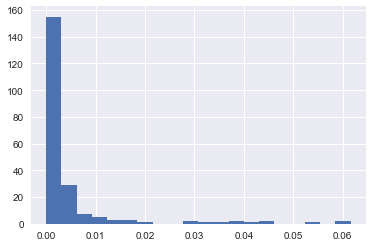

In [61]:
plt.hist(imp['imp'].values, bins=20);